<a href="https://colab.research.google.com/github/deepkick/pytorch_handbook/blob/master/chapter4/section4_3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18

## 転移学習  
PyTorchではtorchvision.modelsに様々な学習済みのモデルが用意されている。  


In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
%matplotlib inline
import time
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


# 転移学習

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-04-09 12:36:55--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.151.21, 54.192.151.98, 54.192.151.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.151.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   128MB/s    in 0.4s    

2020-04-09 12:36:56 (128 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

In [0]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
#画像とラベルを読み込む
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5,
                                             shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [6]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([5, 3, 224, 224])
torch.float32


In [7]:
#ネットワークalexnetの定義
# pretrained=True にすることで、学習済みの重みを読み込むことができる
net = models.alexnet(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
net

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
#ネットワークのパラメータを凍結
#最終層以外の重みを凍結する。requires_grad=Falseにすると、background時に重みを更新しないようにすることができる。
#最後に最終層のみを2クラス分類用に上書きする。上書きした最終層は重みが更新される。
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
#最適化関数
#スケジューラを使用した学習率の調整部分
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
num_epochs = 15

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/15], Loss: 1.3903, val_loss: 1.1038, val_acc: 0.8039, lr：0.01
Epoch [2/15], Loss: 1.2635, val_loss: 2.1055, val_acc: 0.8627, lr：0.01
Epoch [3/15], Loss: 0.9805, val_loss: 1.5587, val_acc: 0.8954, lr：0.01
Epoch [4/15], Loss: 0.9265, val_loss: 1.5520, val_acc: 0.8889, lr：0.01
Epoch [5/15], Loss: 0.6481, val_loss: 1.5295, val_acc: 0.9020, lr：0.01
Epoch [6/15], Loss: 0.9707, val_loss: 1.1075, val_acc: 0.9150, lr：0.01
Epoch [7/15], Loss: 0.5804, val_loss: 1.2145, val_acc: 0.9150, lr：0.01
Epoch [8/15], Loss: 0.7261, val_loss: 1.1190, val_acc: 0.9150, lr：0.01
Epoch [9/15], Loss: 0.4380, val_loss: 1.5520, val_acc: 0.8758, lr：0.01
Epoch [10/15], Loss: 0.8657, val_loss: 1.2272, val_acc: 0.8824, lr：0.01
Epoch [11/15], Loss: 0.2718, val_loss: 1.1181, val_acc: 0.8889, lr：0.001
Epoch [12/15], Loss: 0.5158, val_loss: 1.1422, val_acc: 0.8889, lr：0.001
Epoch [13/15], Loss: 0.4095, val_loss: 1.2227, val_acc: 0.8824, lr：0.001
Epoch [14/15], Loss: 0.3035, val_loss: 1.3265, val_acc: 0.8824, lr：0.0

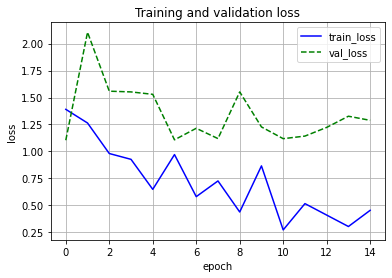

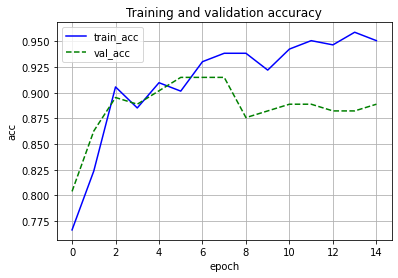

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()